In [0]:
# setup environment
!pip install kappamodules
!pip install torch_geometric

In [0]:
# torch_cluster often doesnt support newest pytorch version which is by default installed in colab -> install older one
!pip install torch==2.3.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# install torch_scatter
!pip install torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [0]:
# check successful setup
import torch
print(torch.__version__)
device = torch.device("cuda")
torch.cuda.get_device_name(device)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr

In [0]:
# clone repo
!git clone https://github.com/BenediktAlkin/upt-minimal.git
%cd upt-minimal

# 4 Pointcloud Classification

Now we know how the model and the decoder works, but we've only trained with images (regular grid data).
We'll want to train UPT on irregular grid data, so lets do it. First, we need a dataset but since we
are already familiar with CIFAR10, we'll simply treat it as a pointcloud. So every pixel is a point in 2D
space that has an RGB value. So essentially, we convert CIFAR10 into a sparse tensor representation
which we'll call `SparseCIFAR10`.

To illustrate the sparse representation better, we'll simply drop some pixels in the input (which we
can now easily do because the encoder with a supernode pooling as initial layer can handle arbitrary
pointclouds).

<img width="60%" src="https://raw.githubusercontent.com/BenediktAlkin/upt-minimal/main/schematics/upt_sparse_classifier.svg">

Now dataloading gets a bit trickier, because we need supernodes and we need to create a sparse tensor 
via the `collate_fn` of the pytorch [DataLoader](https://pytorch.org/docs/stable/data.html).
We'll do this via an object, which we'll call `SparseImageClassifierCollator`.

To start, lets initialize the dataset and visualize a sample:

In [2]:
# initialize CIFAR10
from upt.datasets.sparse_cifar10_classifier_dataset import SparseCIFAR10ClassifierDataset
from torchvision.transforms import ToTensor

train_dataset = SparseCIFAR10ClassifierDataset(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
    # use half of the inputs for training (32x32 pixels = 1024)
    num_inputs=512,
)

/system/apps/userenv/alkin/v3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


Files already downloaded and verified


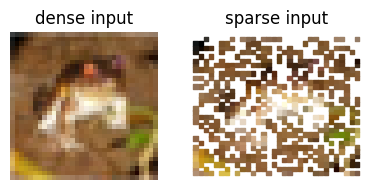

In [12]:
# now plotting is a bit trickier because we have a sparse tensor
# we'll make a scatter plot where each point is colored with the 
# RGB value of the pixel
import matplotlib.pyplot as plt
import einops

# get dense sample
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
train_dataset_dense = CIFAR10(root="./data", train=True, download=True)
dense_sample = train_dataset_dense[0][0]
dense_sample = ToTensor()(dense_sample)
# get sparse sample
sample = train_dataset[0]
x, y = sample["input_pos"].unbind(1)
c = sample["input_feat"]

_, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(einops.rearrange(dense_sample, "three height width -> height width three"))
axes[0].set_title("dense input")
axes[0].set_axis_off()
axes[1].scatter(y, 31 - x, c=c, marker="s", s=10)
axes[1].set_title("sparse input")
axes[1].set_axis_off()
plt.tight_layout()
plt.show()

Lets see how a forward pass looks like for a single sample (so we don't need a collator yet)

In [4]:
from upt.models.encoder_supernodes import EncoderSupernodes

encoder = EncoderSupernodes(
    # CIFAR has 3 channels (RGB)
    input_dim=3,
    # CIFAR is an image dataset -> 2D
    ndim=2,
    # there are 32x32 pixels so positions are in [0, 31], to have roughly the same input as a ViT
    # with patch_size=4, we'll use radius slighly larger than 2
    radius=3,
    # if we split a 32x32 image into 8x8 gridpoints, each point would cover 4x4 pixels, i.e. 16 pixels (=nodes)
    # since we sample supernodes randomly and use a larger radius, it can happen that more than 16 nodes
    # are in the radius of a supernode, so we'll use at maximum 32 connections to each supernode
    max_degree=32,
    # dimension for the supernode pooling -> use same as ViT-T latent dim
    gnn_dim=192,
    # ViT-T latent dimension
    enc_dim=192,
    enc_num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    enc_depth=4,
    # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
    # perc_dim=dim,
    # perc_num_heads=num_heads,
    # num_latent_tokens=32,
)

# for now, we only encode 1 sample, so we need to generate some supernode indices
# later the collator will take care of this
sample = train_dataset[0]
# select 64 random pixels as supernodes
supernode_idxs = torch.randperm(len(sample["input_feat"]))[:64]
# and we need a batch_idx tensor
batch_idx = torch.zeros(len(sample["input_feat"]), dtype=torch.long)
encoded_pointcloud = encoder(
    input_feat=sample["input_feat"],
    input_pos=sample["input_pos"],
    supernode_idxs=supernode_idxs,
    batch_idx=batch_idx,
)
print(f"encoded_pointcloud.shape: {encoded_pointcloud.shape}")

encoded_pointcloud.shape: torch.Size([1, 64, 192])


In this setting, we dont really need an approximator, but we'll keep it for consistency.

In [5]:
from upt.models.approximator import Approximator

approximator = Approximator(
    # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
    input_dim=192,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
)

approximator_output = approximator(encoded_pointcloud)
print(f"approximator_output.shape: {approximator_output.shape}")

approximator_output.shape: torch.Size([1, 64, 192])


The decoder now only uses some transformers, then averages all tokens and classifies the image with a simple linear
head.

In [6]:
from upt.models.decoder_classifier import DecoderClassifier

decoder = DecoderClassifier(
    # tell the decoder the dimension of the input (dim of approximator)
    input_dim=192,
    # CIFAR10 has 10 classes
    num_classes=10,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
)
prediction = decoder(approximator_output)
print(f"prediction.shape: {prediction.shape}")
print(f"decoder predicted class: {prediction.argmax(dim=1)}")

prediction.shape: torch.Size([1, 10])
decoder predicted class: tensor([3])


# Train a model
Now we can put it all together and train an image classifier on a "point cloud of pixels".

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm

from upt.models.approximator import Approximator
from upt.models.decoder_classifier import DecoderClassifier
from upt.models.encoder_supernodes import EncoderSupernodes
from upt.models.upt_sparseimage_classifier import UPTSparseImageClassifier
from upt.datasets.sparse_cifar10_classifier_dataset import SparseCIFAR10ClassifierDataset
from upt.collators.sparseimage_classifier_collator import SparseImageClassifierCollator

# initialize dataset
transform = ToTensor()
train_dataset = SparseCIFAR10ClassifierDataset(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    # use half of the inputs for training (32x32 pixels = 1024)
    num_inputs=512,
)
test_dataset = SparseCIFAR10ClassifierDataset(
    root="./data",
    train=False,
    download=True,
    transform=transform,
    # use all inputs for evaluation (32x32 pixels = 1024)
    num_inputs=1024,
)

# hyperparameters
dim = 192  # ~6M parameter model
num_heads = 3
epochs = 10
batch_size = 256

# initialize model
model = UPTSparseImageClassifier(
    encoder=EncoderSupernodes(
        # CIFAR has 3 channels (RGB)
        input_dim=3,
        # CIFAR is an image dataset -> 2D
        ndim=2,
        # there are 32x32 pixels so positions are in [0, 31], to have roughly the same input as a ViT
        # with patch_size=4, we'll use radius slighly larger than 4
        radius=5,
        # if we split a 32x32 image into 8x8 gridpoints, each point would cover 4x4 pixels, i.e. 16 pixels (=nodes)
        # since we sample supernodes randomly and use a larger radius, it can happen that more than 16 nodes
        # are in the radius of a supernode, so we'll use at maximum 32 connections to each supernode
        max_degree=32,
        # dimension for the supernode pooling -> use same as ViT-T latent dim
        gnn_dim=dim,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=4,
        # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
        # perc_dim=dim,
        # perc_num_heads=num_heads,
        # num_latent_tokens=32,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
    decoder=DecoderClassifier(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # CIFAR10 has 10 classes
        num_classes=10,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

# setup dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=SparseImageClassifierCollator(num_supernodes=64, deterministic=False),
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    collate_fn=SparseImageClassifierCollator(num_supernodes=64, deterministic=True),
)

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
test_accuracy = 0.0
train_losses = []
train_accuracies = []
test_accuracies = []
loss = None
train_accuracy = None
for _ in range(epochs):
    # train for an epoch
    for batch in train_dataloader:
        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
        )
        y = batch["target_class"].to(device)
        loss = F.cross_entropy(y_hat, y)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        train_accuracy = (y_hat.argmax(dim=1) == y).sum() / y.numel()
        update += 1
        pbar.update()
        pbar.set_description(
            f"train_loss: {loss.item():.4f} "
            f"train_accuracy: {train_accuracy * 100:4.1f}% "
            f"test_accuracy: {test_accuracy * 100:4.1f}%"
        )
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

    # evaluate
    num_correct = 0
    for batch in test_dataloader:
        with torch.no_grad():
            y_hat = model(
                input_feat=batch["input_feat"].to(device),
                input_pos=batch["input_pos"].to(device),
                supernode_idxs=batch["supernode_idxs"].to(device),
                batch_idx=batch["batch_idx"].to(device),
            )
        y = batch["target_class"].to(device)
        num_correct += (y_hat.argmax(dim=1) == y).sum().item()
    test_accuracy = num_correct / len(test_dataset)
    test_accuracies.append(test_accuracy)
    pbar.set_description(
        f"train_loss: {loss.item():.4f} "
        f"train_accuracy: {train_accuracy * 100:4.1f}% "
        f"test_accuracy: {test_accuracy * 100:4.1f}%"
    )
pbar.close()

Files already downloaded and verified
Files already downloaded and verified
parameters: 5.7M


train_loss: ????? train_accuracy: ????% test_accuracy: ????%:   0%|                                                                                                                     | 0/1950 [00:00<?, ?it/s]

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

Lets plot the learning curves

In [ ]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(range(len(train_losses)), train_losses)
axes[0].set_xlabel("Updates")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Train Loss")
axes[0].legend()
axes[0].grid(True)
axes[1].plot(range(len(train_accuracies)), train_accuracies)
axes[1].set_xlabel("Updates")
axes[1].set_ylabel("Train Accuracy")
axes[1].set_title("Train Accuracy")
axes[1].legend()
axes[1].grid(True)
axes[2].plot(range(len(test_accuracies)), test_accuracies, marker="o")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("Test Accuracy")
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.show()

Now we can also classify pointclouds with UPT.